In [74]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

In [2]:
filenames = glob.glob("../data/CICIDS2017/MachineLearningCVE/*")
filenames

['../data/CICIDS2017/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
 '../data/CICIDS2017/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
 '../data/CICIDS2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
 '../data/CICIDS2017/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv',
 '../data/CICIDS2017/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv',
 '../data/CICIDS2017/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv',
 '../data/CICIDS2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
 '../data/CICIDS2017/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv']

In [7]:
for i,fn in enumerate(filenames):
    print("load file",fn)
    if i==0:
        df = pd.read_csv(fn)
    else:
        df_temp = pd.read_csv(fn)
        df = pd.concat([df,df_temp])
        del df_temp

load file ../data/CICIDS2017/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
load file ../data/CICIDS2017/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
load file ../data/CICIDS2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
load file ../data/CICIDS2017/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv
load file ../data/CICIDS2017/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv
load file ../data/CICIDS2017/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv
load file ../data/CICIDS2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
load file ../data/CICIDS2017/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv


# Explore dataset

In [27]:
df.shape

(2830743, 79)

In [44]:
print("the number of duplicates: ",len(df)-len(df.drop_duplicates(ignore_index=True)))
print("the ratio of duplicates: ",(len(df)-len(df.drop_duplicates(ignore_index=True)))/len(df))

the number of duplicates:  308381
the ratio of duplicates:  0.10893994968812075


In [75]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,389,113095465,48,24,9668,10012,403,0,201.416667,203.548293,...,32,203985.500,5.758373e+05,1629110,379,13800000.0,4.277541e+06,16500000,6737603,BENIGN
1,389,113473706,68,40,11364,12718,403,0,167.117647,171.919413,...,32,178326.875,5.034269e+05,1424245,325,13800000.0,4.229413e+06,16500000,6945512,BENIGN
2,0,119945515,150,0,0,0,0,0,0.000000,0.000000,...,0,6909777.333,1.170000e+07,20400000,6,24400000.0,2.430000e+07,60100000,5702188,BENIGN
3,443,60261928,9,7,2330,4221,1093,0,258.888889,409.702161,...,20,0.000,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN
4,53,269,2,2,102,322,51,51,51.000000,0.000000,...,32,0.000,0.000000e+00,0,0,0.0,0.000000e+00,0,0,BENIGN


In [57]:
print("Column counts with negative values")
numeric_cols = _numeric_col(df)
aa = (df[numeric_cols]<0).sum(axis=0)
print(aa[aa>0])

Column counts with negative values
 Flow Duration                  115
Flow Bytes/s                     85
 Flow Packets/s                 115
 Flow IAT Mean                  115
 Flow IAT Max                   115
 Flow IAT Min                  2891
 Fwd IAT Min                     17
 Fwd Header Length               35
 Bwd Header Length               22
 Fwd Header Length.1             35
Init_Win_bytes_forward      1001189
 Init_Win_bytes_backward    1441552
 min_seg_size_forward            35
dtype: int64


# Preprocess DF

- drop data with missing values
- drop data with negative values
- drop data with only a single value
- remove duplicates

In [42]:
def preprocess_df(df):
    print("original df: ", df.shape)
    print("+"*50)

    print("drop NA")
    df_proc = df.dropna(axis=0)
    print("drop rows: ", df.shape[0]-df_proc.shape[0])
    print("data size after dropping", df_proc.shape)
    print("+"*50)
    
    tmp = df_proc.shape
    print("remove data having negative values")
    numeric_cols = _numeric_col(df_proc)
    df_proc = df_proc[(df_proc[numeric_cols]>=0).all(axis=1)]
    print("drop rows: ", tmp[0]-df_proc.shape[0])
    print("data after droppnig negative: ", df_proc.shape)
    print("+"*50)
    
    tmp = df_proc.shape
    print("drop deficient columns")
    dfc_col = find_deficient_col(df_proc)
    print("//".join(dfc_col))
    df_proc.drop(columns = dfc_col, inplace = True)
    print("drop columns: ", tmp[1]-df_proc.shape[1])
    print("data after droppnig columns: ", df_proc.shape)
    print("+"*50)
    
    tmp = df_proc.shape
    print("remove duplicates")
    df_proc.drop_duplicates(inplace=True, ignore_index=True)
    print("drop rows: ", tmp[0]-df_proc.shape[0])
    
    print("final df shape:", df_proc.shape)
    print("final differences: ", df.shape[0]-df_proc.shape[0],
         df.shape[1]-df_proc.shape[1])
    
    return df_proc

def _numeric_col(df):
    cols = []
    for cn in df.columns:
        col = df[cn]
        if col.dtypes in ['int64','float64']:
            cols.append(cn)
    return cols

def find_deficient_col(df):
    dfc_col = []
    for col in df.columns:
        if len(df[col].unique()) ==1:
            dfc_col.append(col)
    return dfc_col

In [43]:
df_proc = preprocess_df(df)

original df:  (2830743, 79)
++++++++++++++++++++++++++++++++++++++++++++++++++
drop NA
drop rows:  1358
data size after dropping (2829385, 79)
++++++++++++++++++++++++++++++++++++++++++++++++++
remove data having negative values
drop rows:  1443266
data after droppnig negative:  (1386119, 79)
++++++++++++++++++++++++++++++++++++++++++++++++++
drop deficient columns
 Bwd PSH Flags// Bwd URG Flags//Fwd Avg Bytes/Bulk// Fwd Avg Packets/Bulk// Fwd Avg Bulk Rate// Bwd Avg Bytes/Bulk// Bwd Avg Packets/Bulk//Bwd Avg Bulk Rate
drop columns:  8
data after droppnig columns:  (1386119, 71)
++++++++++++++++++++++++++++++++++++++++++++++++++
remove duplicates
drop rows:  83140
final df shape: (1302979, 71)
final differences:  1527764 8


## Standardize Data

- skewness test on variables

In [61]:
df_proc.skew()

/tmp/ipykernel_98257/2106592216.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_proc.skew()


 Destination Port                1.482251
 Flow Duration                   1.087070
 Total Fwd Packets             843.259766
 Total Backward Packets        869.990305
Total Length of Fwd Packets    707.730291
                                  ...    
 Active Min                     44.646077
Idle Mean                        1.935233
 Idle Std                        7.300747
 Idle Max                        1.834911
 Idle Min                        2.035740
Length: 70, dtype: float64

In [67]:
def histogram_dataframe(df):
    for colname in df.columns:
        col = df[colname]
    #     print(colname, col.dtypes)
        if col.dtypes in ['int64','float64']:
            print(min(col))
    #         print(len(col)-sum(np.isfinite(col)), sum(pd.isna(col)), sum(pd.isnull(col)),
    #               max(col[np.isfinite(col)]), min(col[np.isfinite(col)]),len(col.unique()))
            plt.title(colname+" "+str(col.skew()))
            plt.hist(col[np.isfinite(col)])
            plt.show()

1


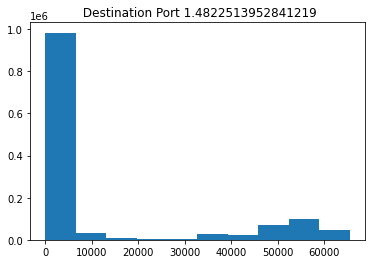

0


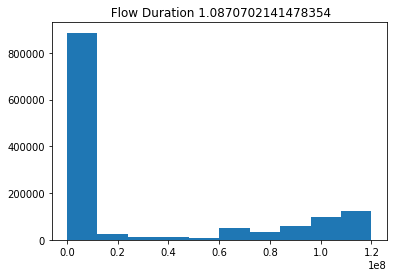

1


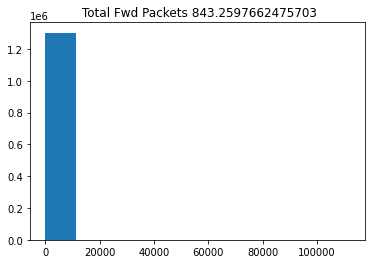

1


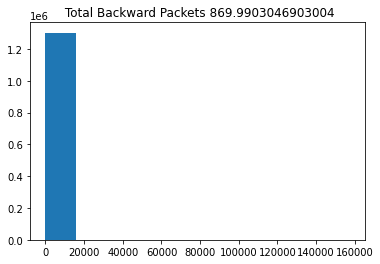

0


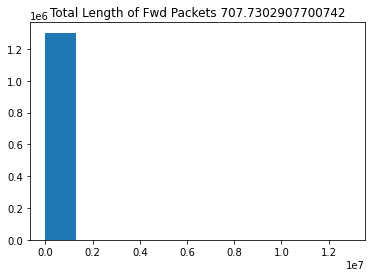

0


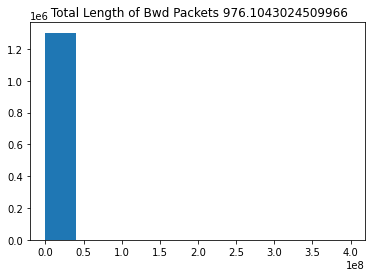

0


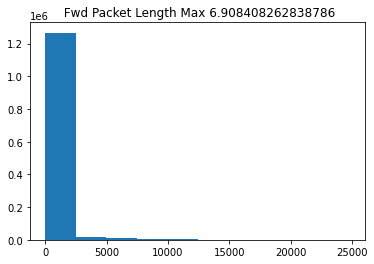

0


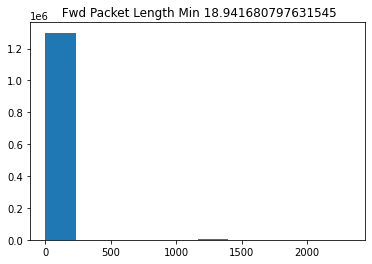

0.0


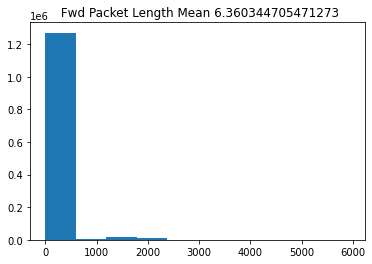

0.0


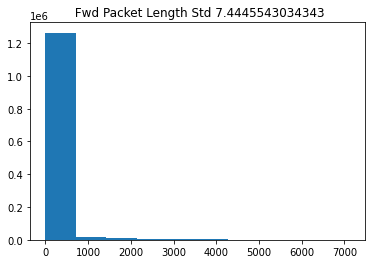

0


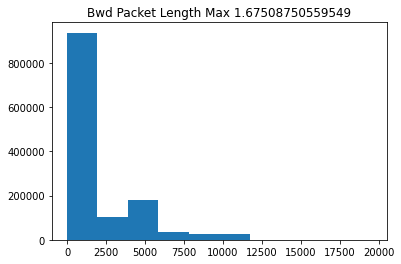

0


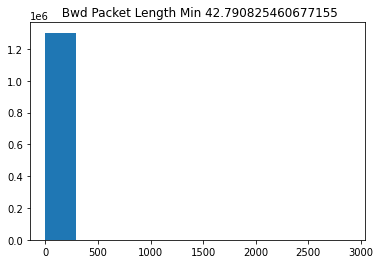

0.0


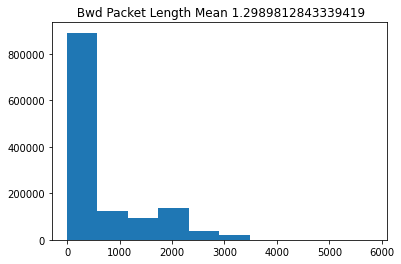

0.0


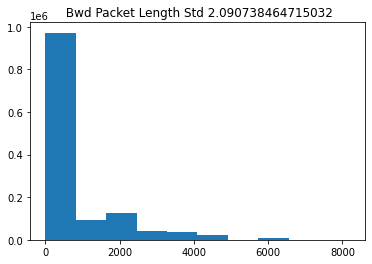

0.0


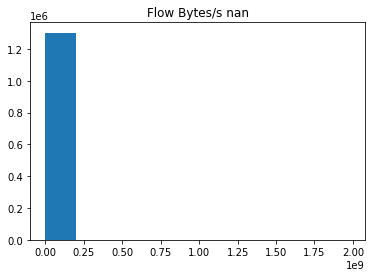

0.0250771356


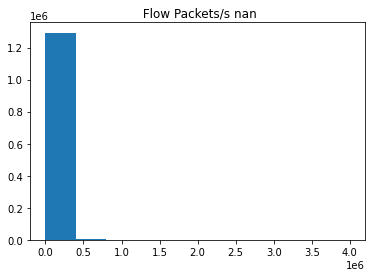

0.0


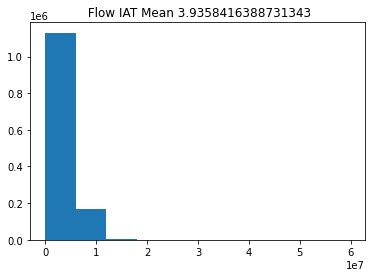

0.0


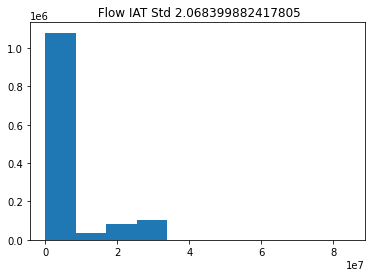

0


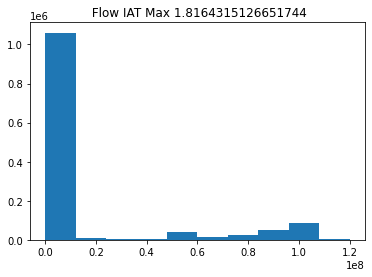

0


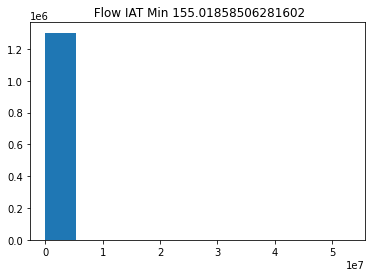

0


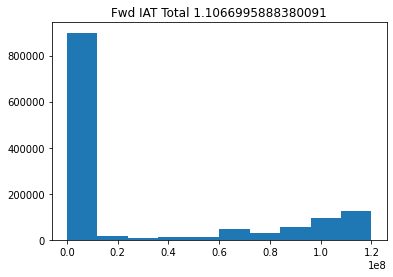

0.0


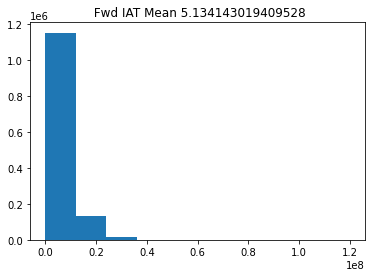

0.0


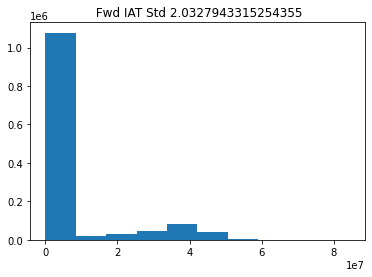

0


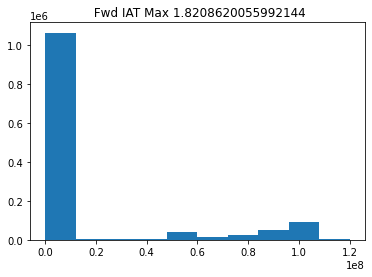

0


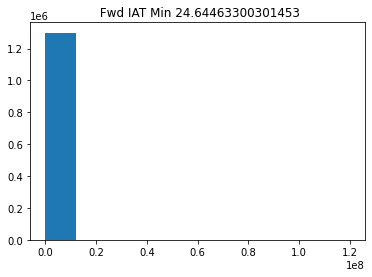

0


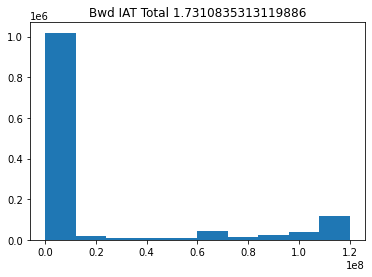

0.0


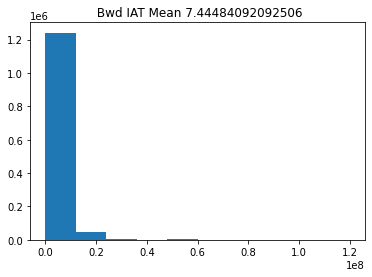

0.0


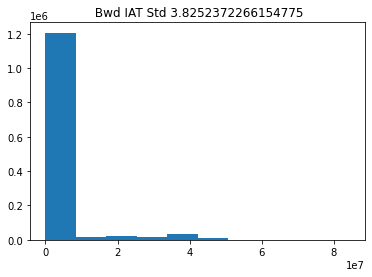

0


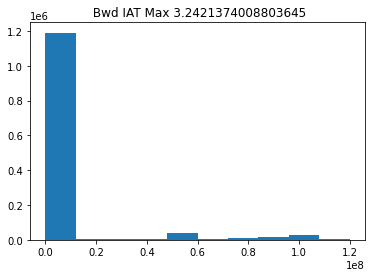

0


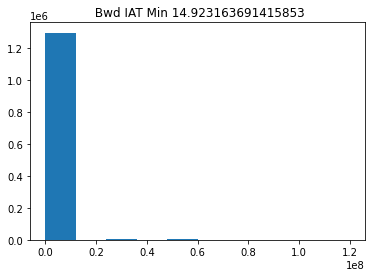

0


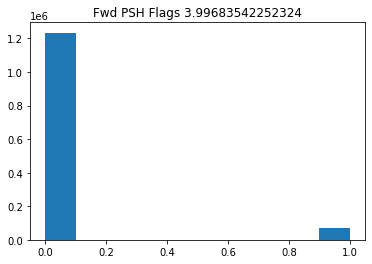

0


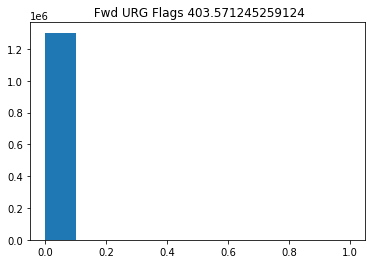

20


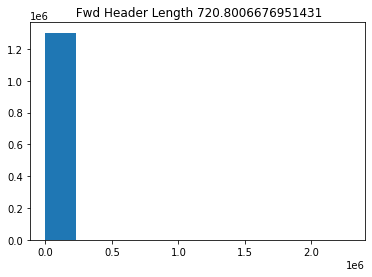

20


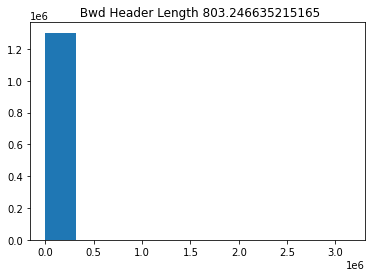

0.0


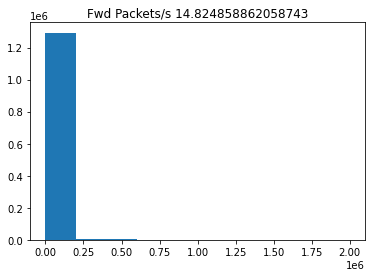

0.0


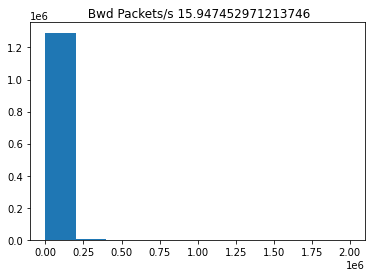

0


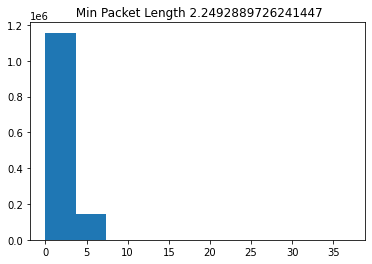

0


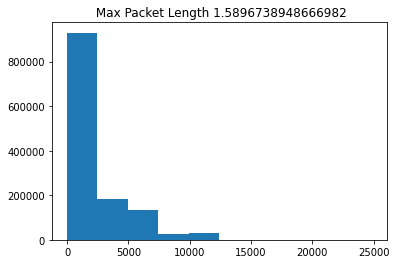

0.0


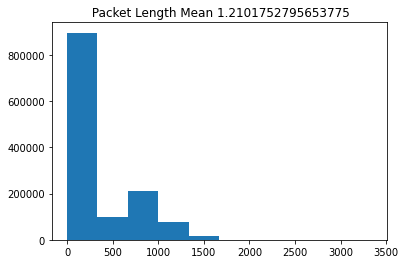

0.0


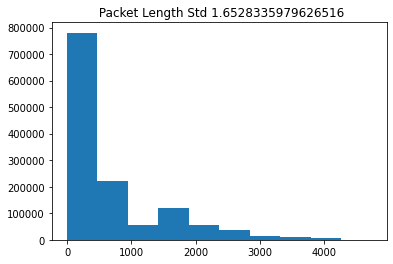

0.0


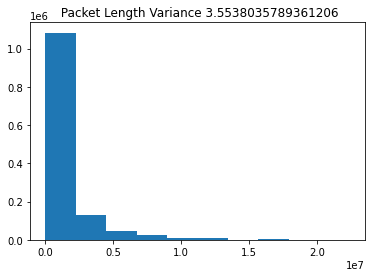

0


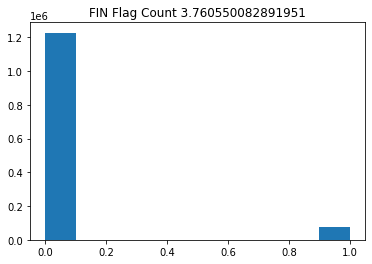

0


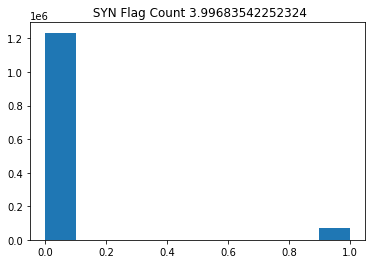

0


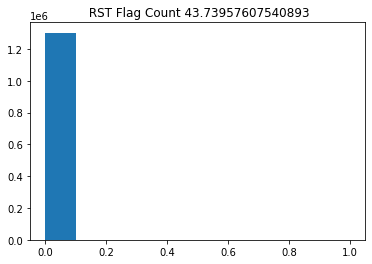

0


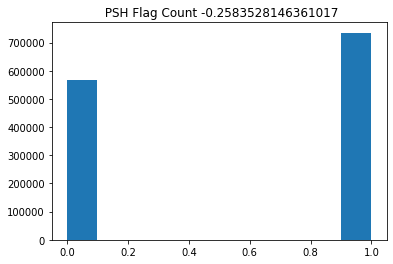

0


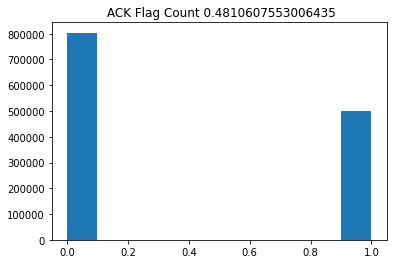

0


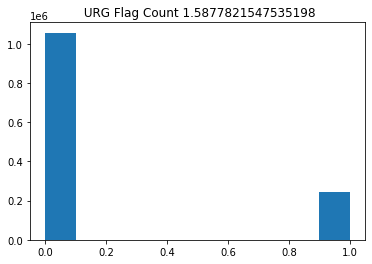

0


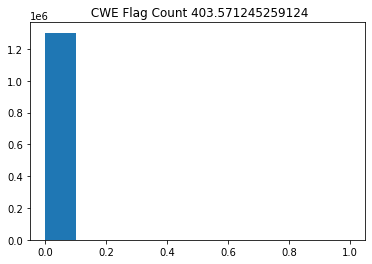

0


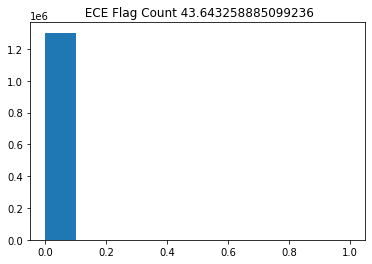

0


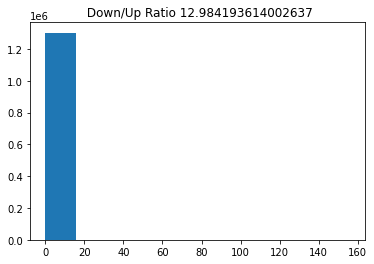

0.0


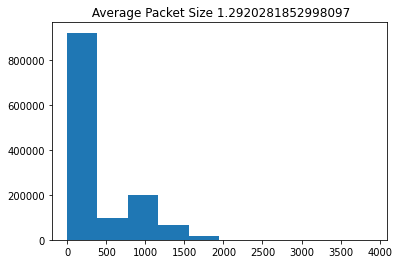

0.0


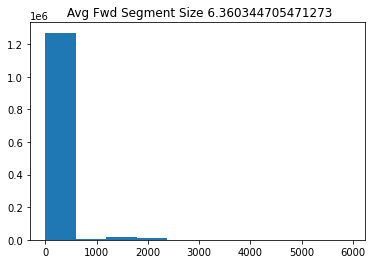

0.0


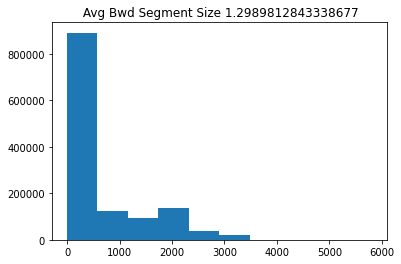

20


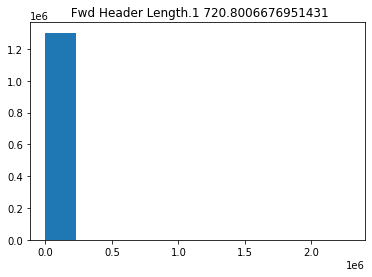

1


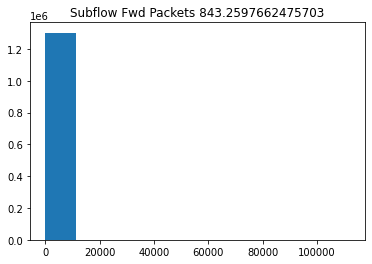

0


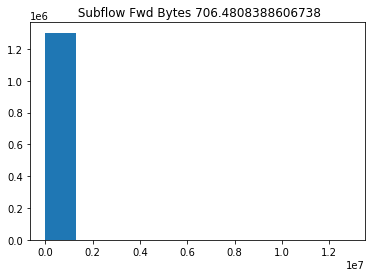

1


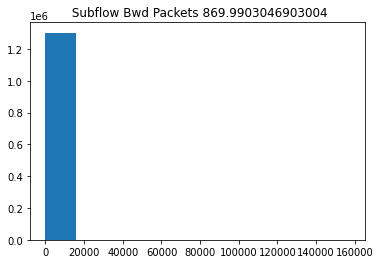

0


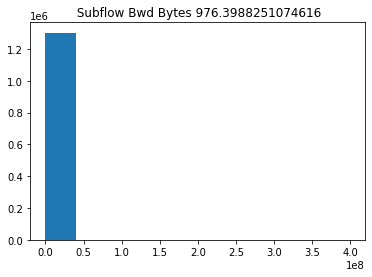

0


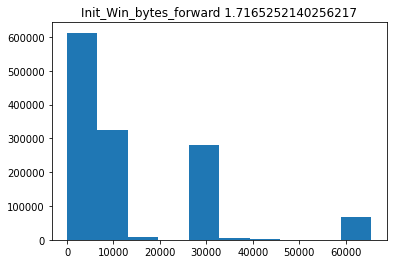

0


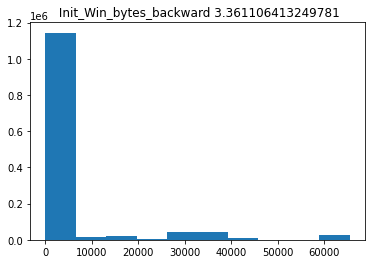

0


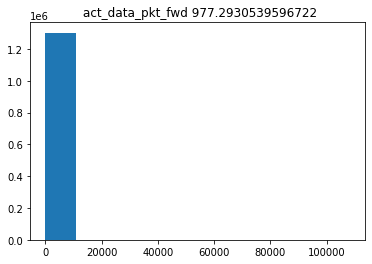

20


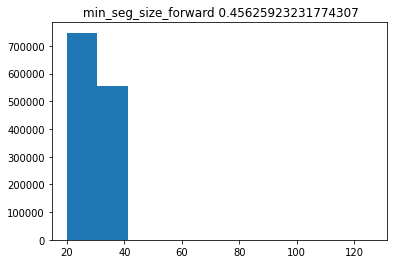

0.0


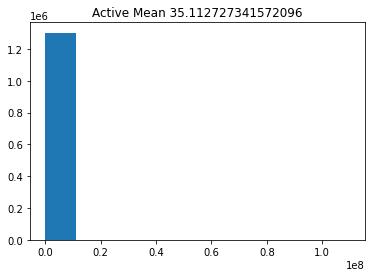

0.0


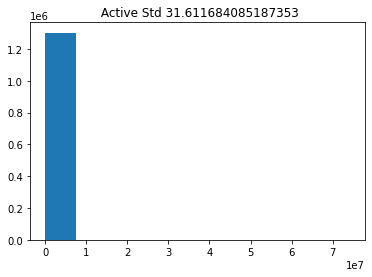

0


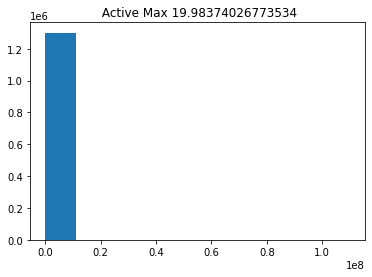

0


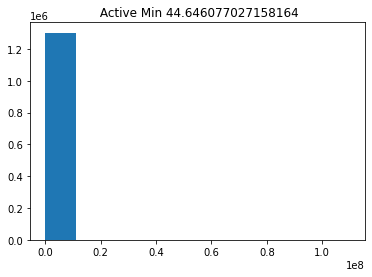

0.0


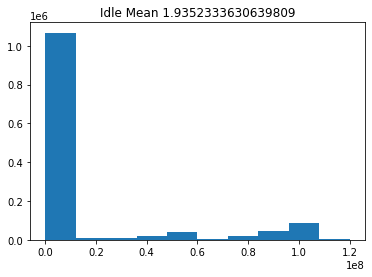

0.0


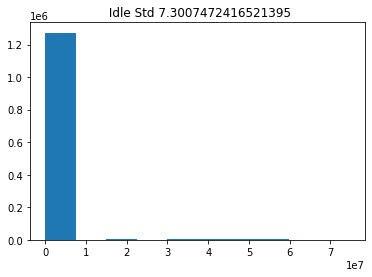

0


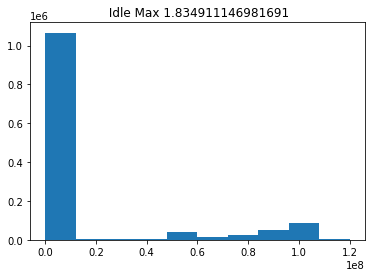

0


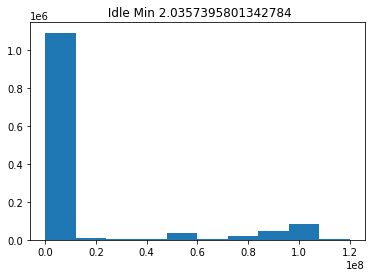

In [68]:
histogram_dataframe(df_proc)

# Outlier Processing

In [71]:
import copy
def clip_outlier(df):
    df_proc = copy.deepcopy(df)
    for coln in df_proc.columns:
        col = df_proc[coln]
        if col.dtypes in ['int64','float64']:
            q3 = col.quantile(0.75)
            col.clip(None,q3*2.5, inplace=True)
    return df_proc

In [72]:
df_proc2 = clip_outlier(df_proc)

1.0


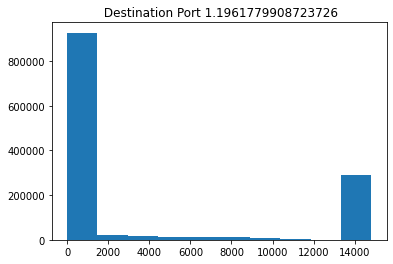

0


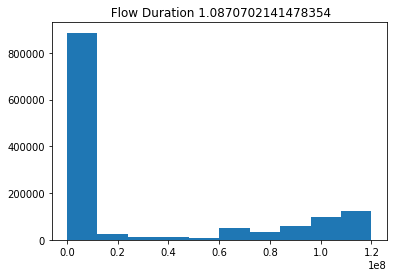

1.0


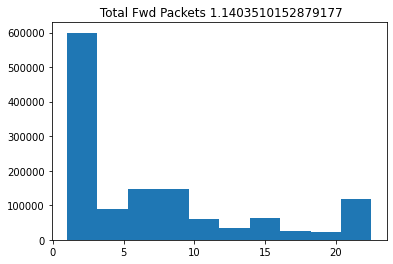

1.0


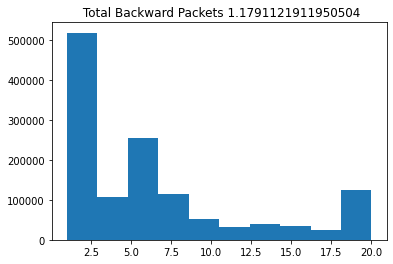

0.0


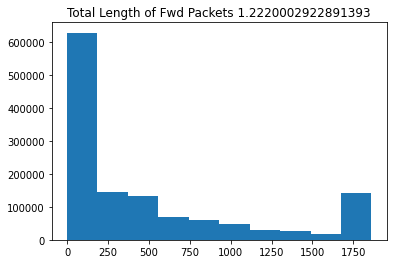

0.0


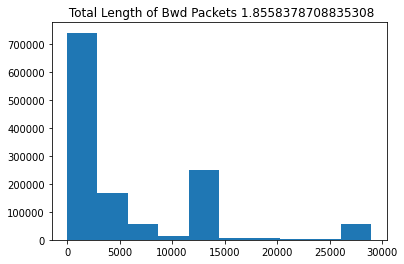

0.0


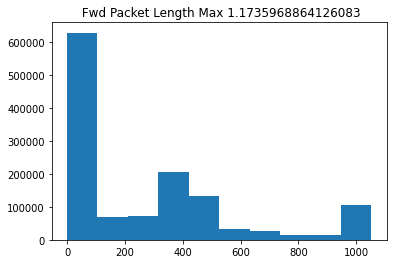

0.0


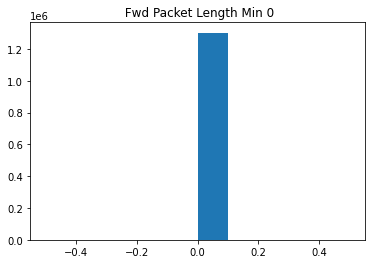

0.0


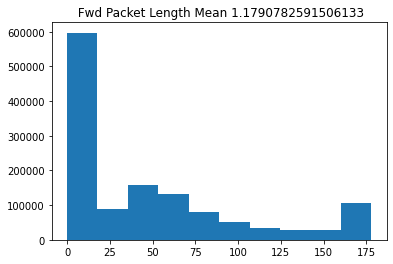

0.0


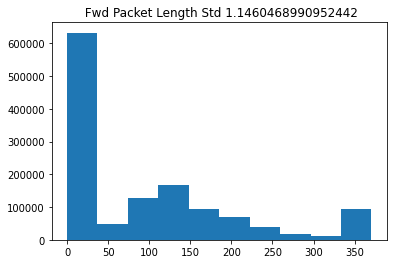

0.0


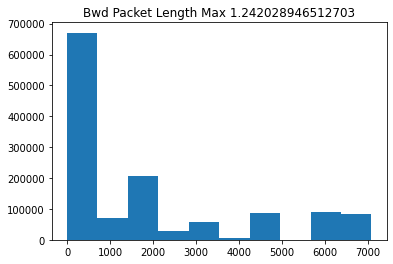

0.0


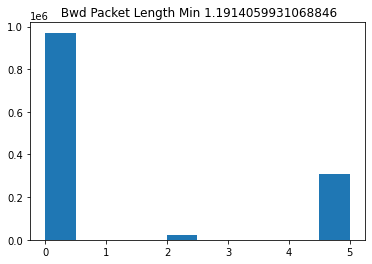

0.0


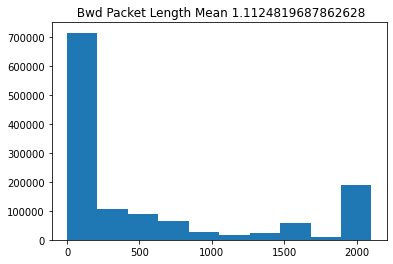

0.0


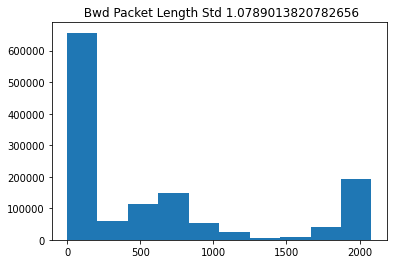

0.0


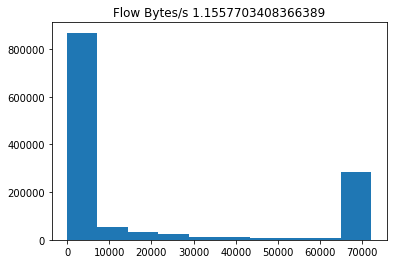

0.0250771356


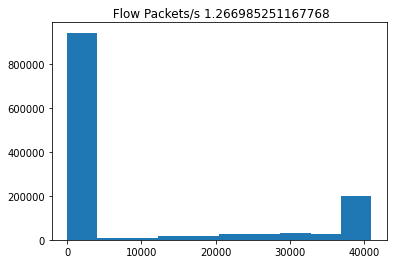

0.0


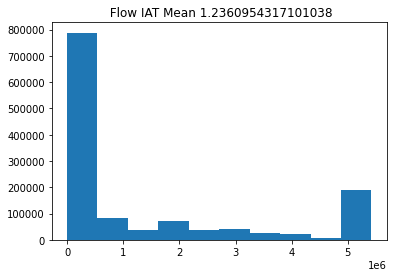

0.0


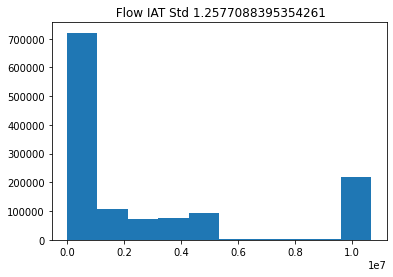

0.0


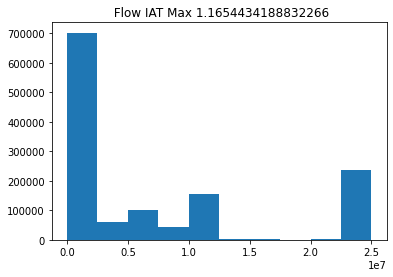

0.0


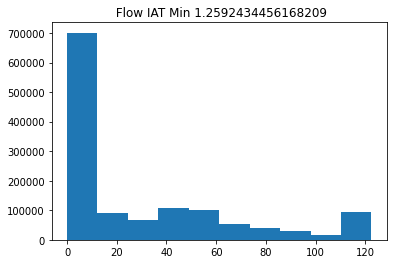

0


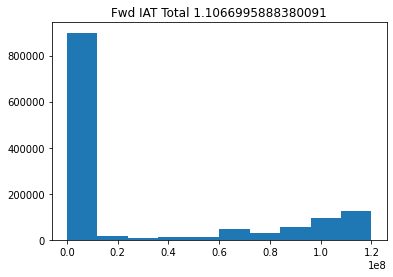

0.0


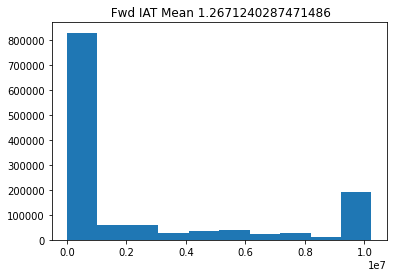

0.0


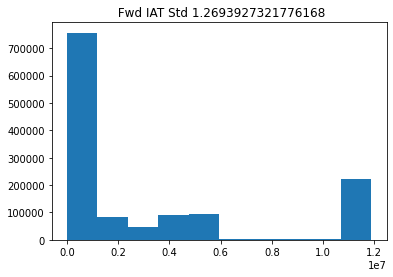

0.0


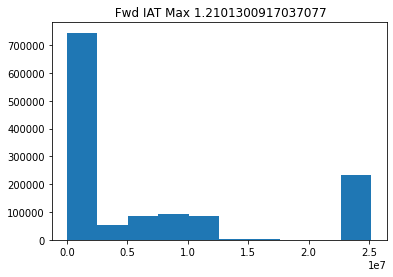

0.0


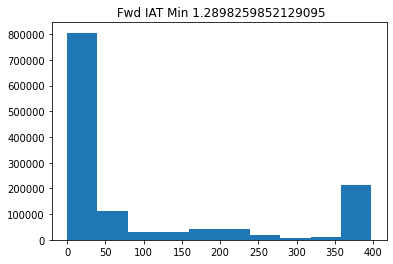

0.0


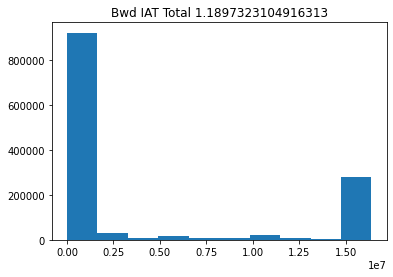

0.0


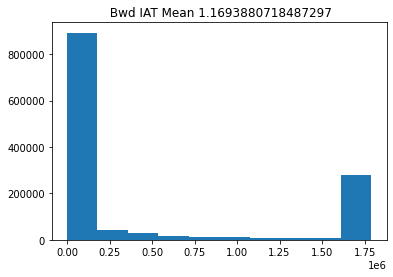

0.0


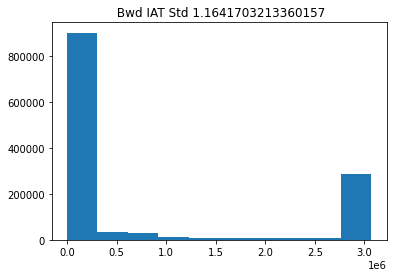

0.0


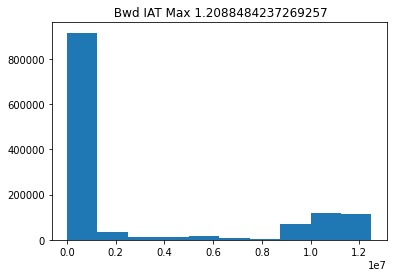

0.0


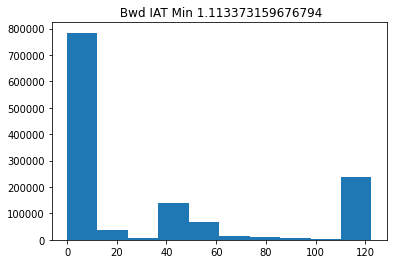

0.0


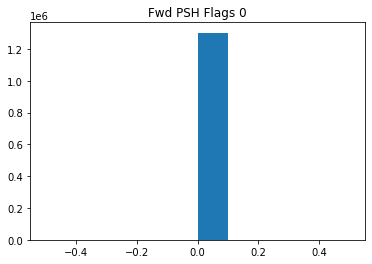

0.0


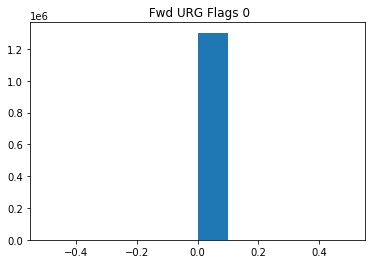

20.0


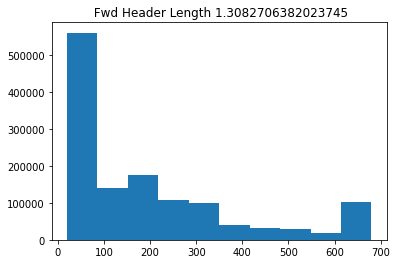

20.0


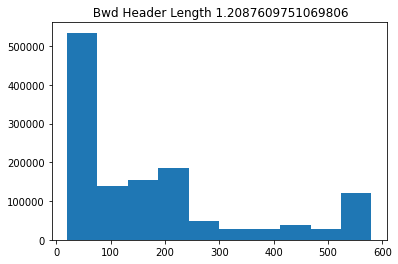

0.0


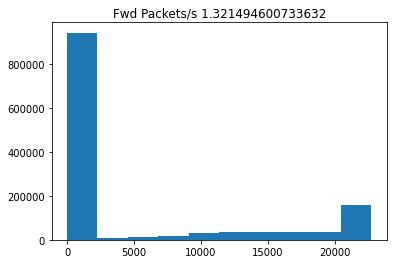

0.0


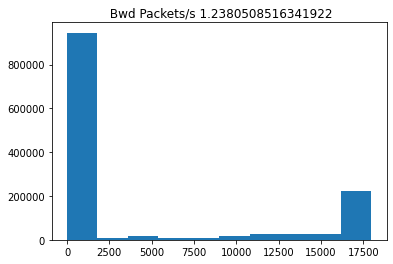

0.0


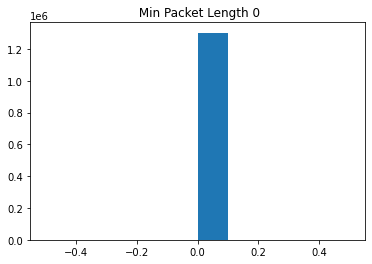

0.0


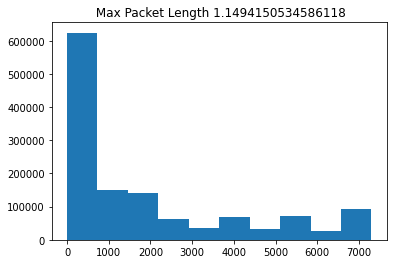

0.0


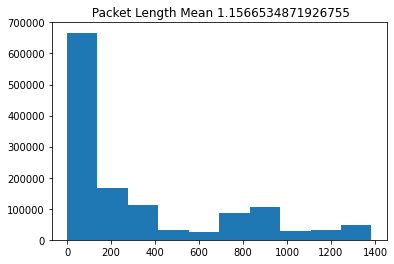

0.0


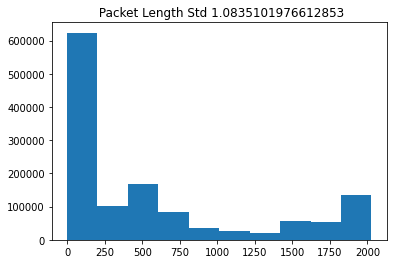

0.0


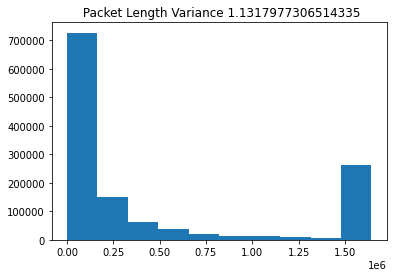

0.0


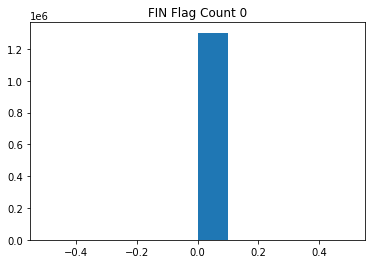

0.0


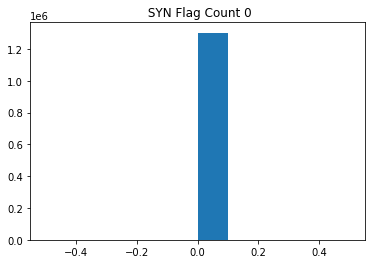

0.0


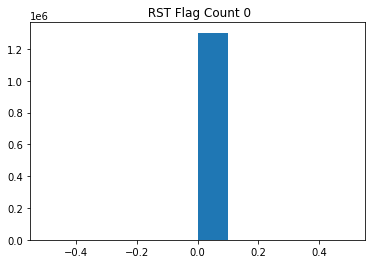

0


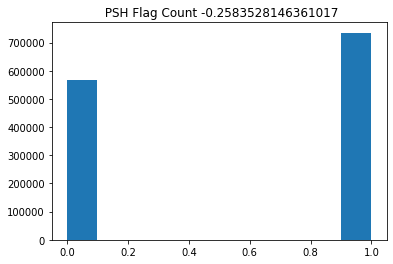

0


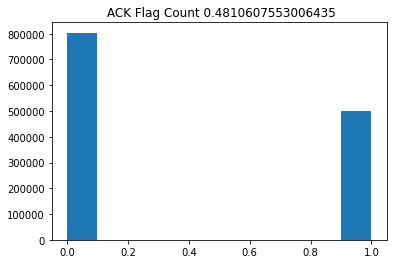

0.0


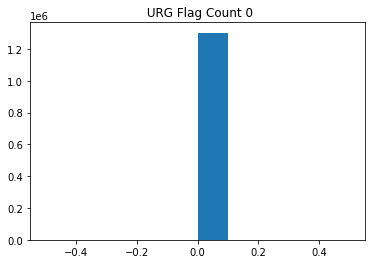

0.0


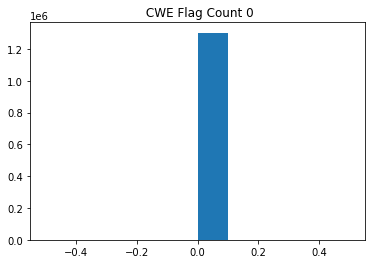

0.0


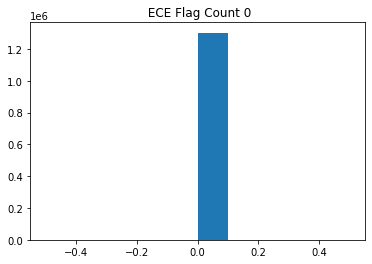

0.0


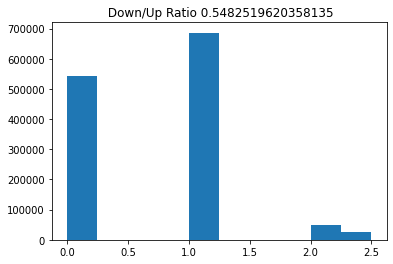

0.0


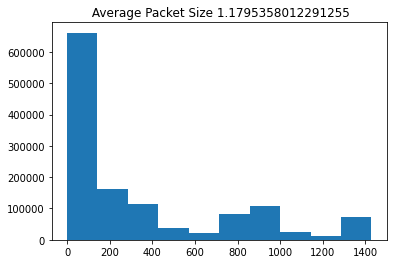

0.0


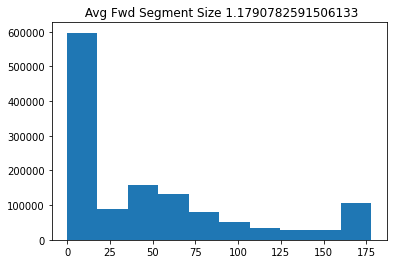

0.0


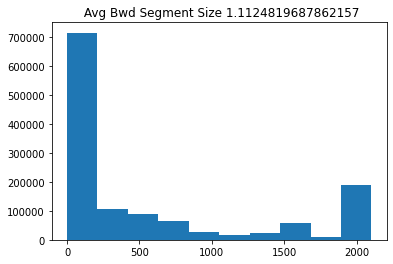

20.0


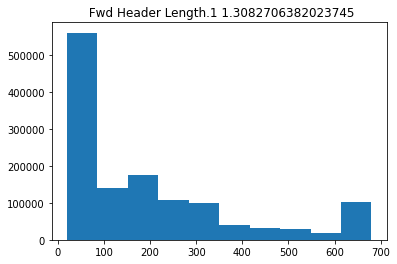

1.0


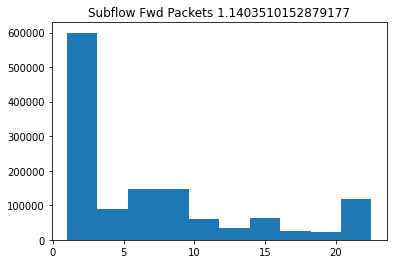

0.0


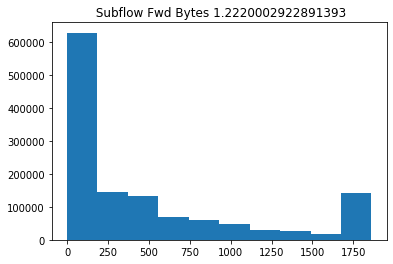

1.0


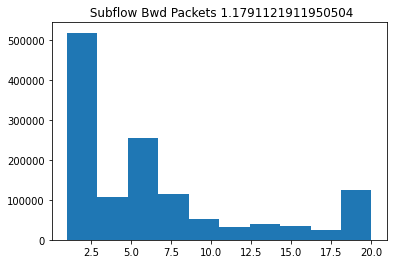

0.0


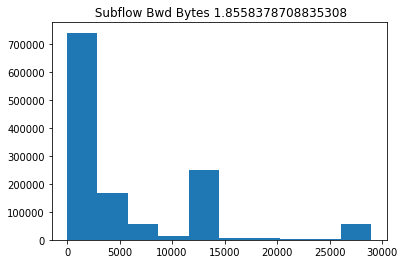

0


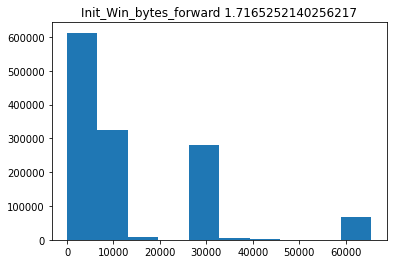

0.0


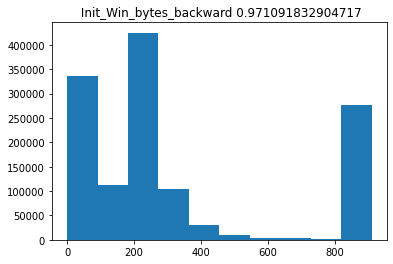

0.0


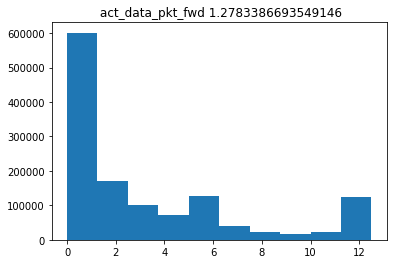

20.0


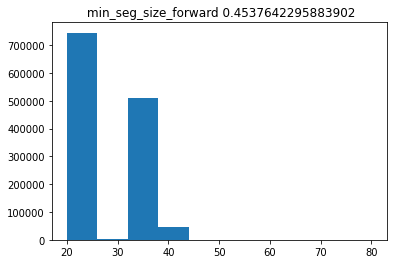

0.0


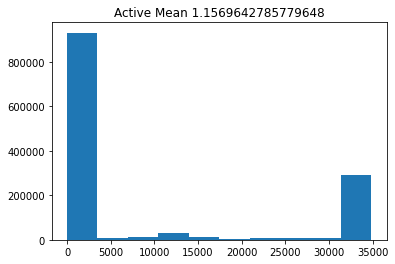

0.0


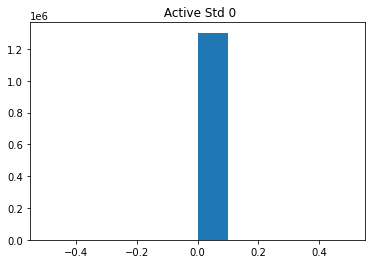

0.0


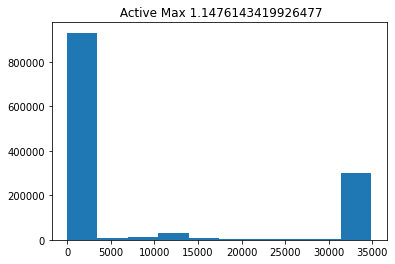

0.0


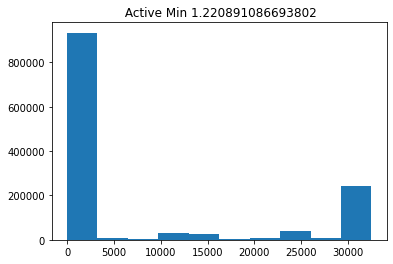

0.0


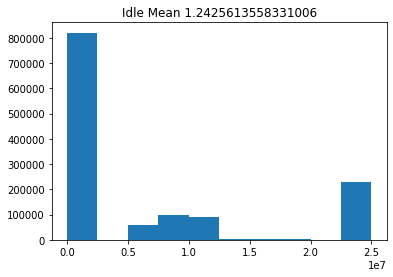

0.0


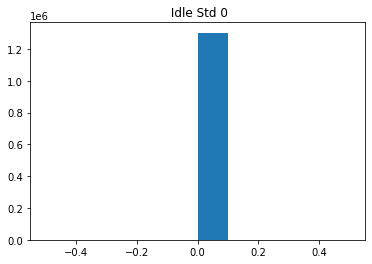

0.0


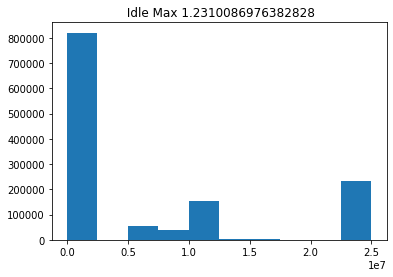

0.0


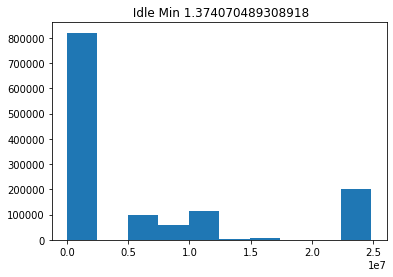

In [73]:
histogram_dataframe(df_proc2)

In [85]:
for colname in df.columns:
    col = df[colname]
    print(colname,",", col.dtypes)
#     if col.dtypes in ['int64','float64']:

 Destination Port , int64
 Flow Duration , int64
 Total Fwd Packets , int64
 Total Backward Packets , int64
Total Length of Fwd Packets , int64
 Total Length of Bwd Packets , int64
 Fwd Packet Length Max , int64
 Fwd Packet Length Min , int64
 Fwd Packet Length Mean , float64
 Fwd Packet Length Std , float64
Bwd Packet Length Max , int64
 Bwd Packet Length Min , int64
 Bwd Packet Length Mean , float64
 Bwd Packet Length Std , float64
Flow Bytes/s , float64
 Flow Packets/s , float64
 Flow IAT Mean , float64
 Flow IAT Std , float64
 Flow IAT Max , int64
 Flow IAT Min , int64
Fwd IAT Total , int64
 Fwd IAT Mean , float64
 Fwd IAT Std , float64
 Fwd IAT Max , int64
 Fwd IAT Min , int64
Bwd IAT Total , int64
 Bwd IAT Mean , float64
 Bwd IAT Std , float64
 Bwd IAT Max , int64
 Bwd IAT Min , int64
Fwd PSH Flags , int64
 Bwd PSH Flags , int64
 Fwd URG Flags , int64
 Bwd URG Flags , int64
 Fwd Header Length , int64
 Bwd Header Length , int64
Fwd Packets/s , float64
 Bwd Packets/s , float64
 Min

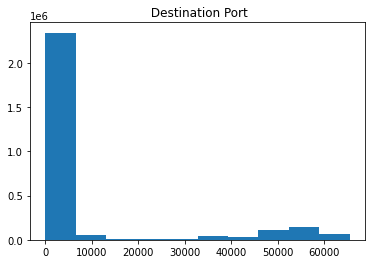

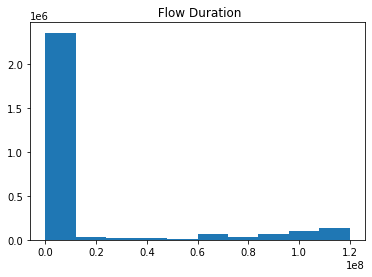

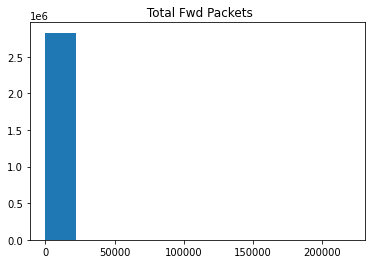

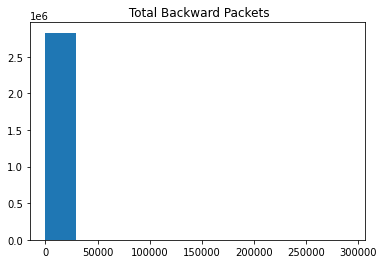

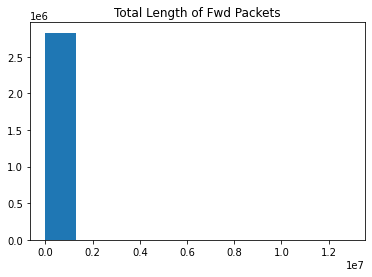

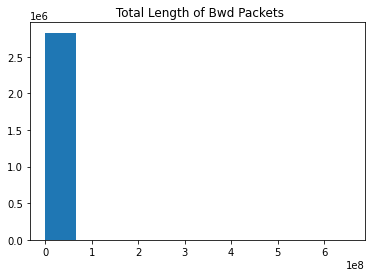

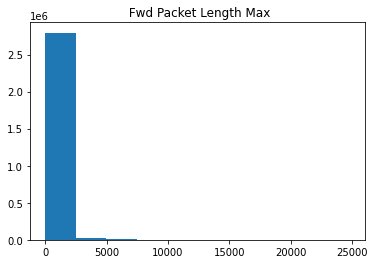

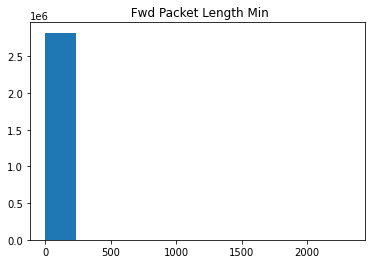

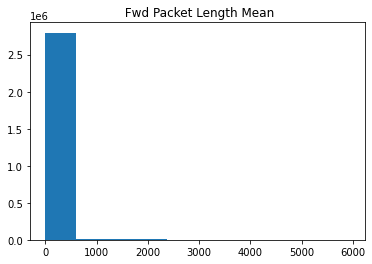

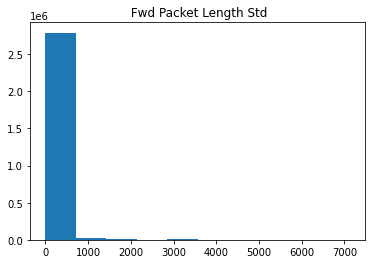

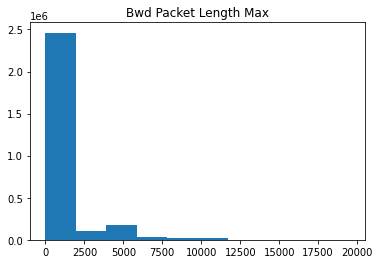

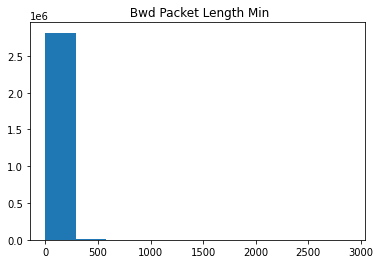

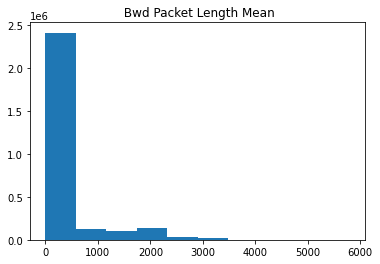

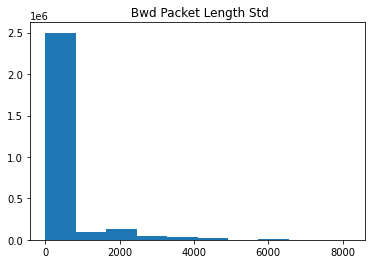

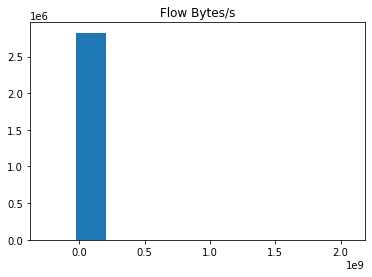

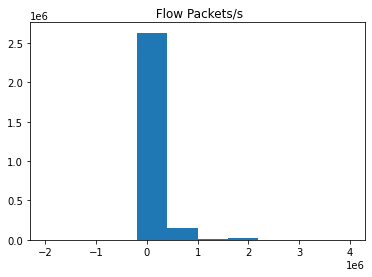

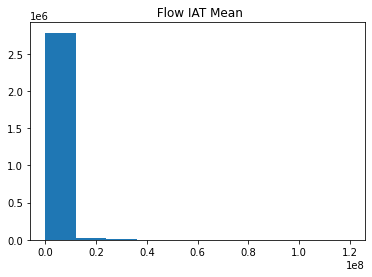

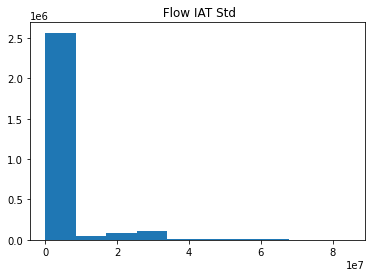

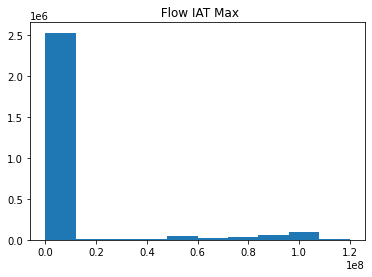

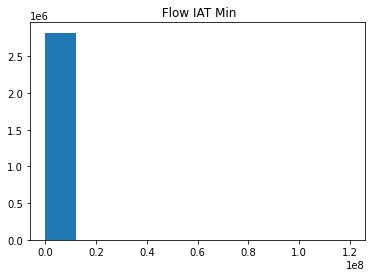

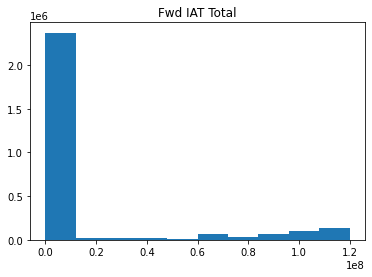

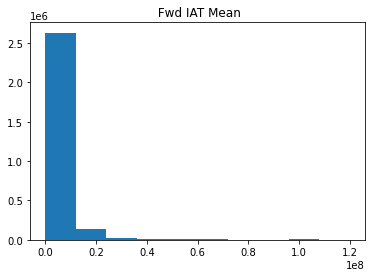

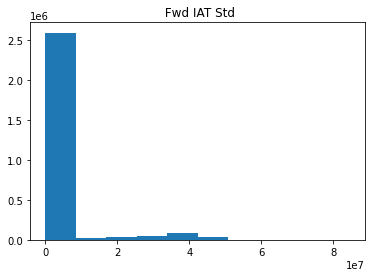

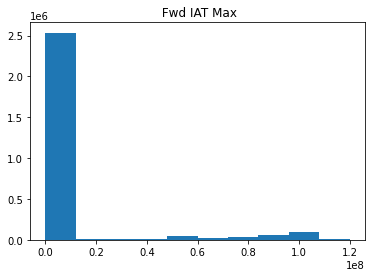

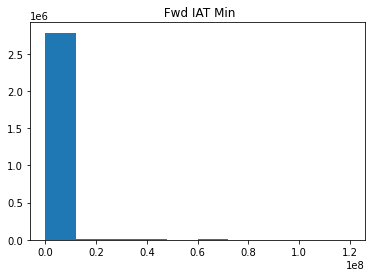

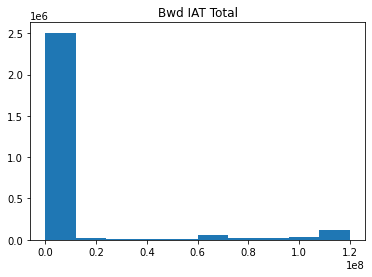

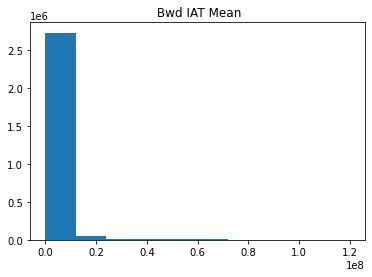

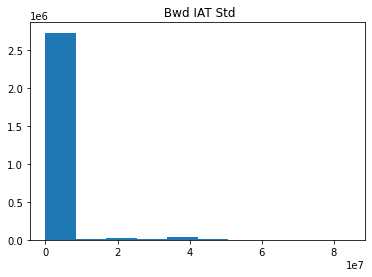

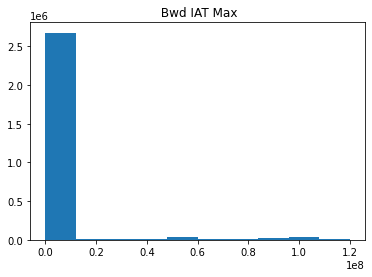

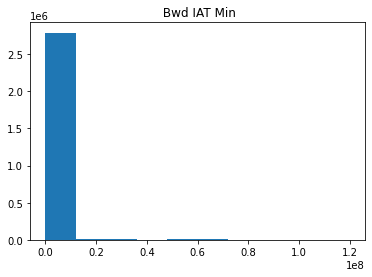

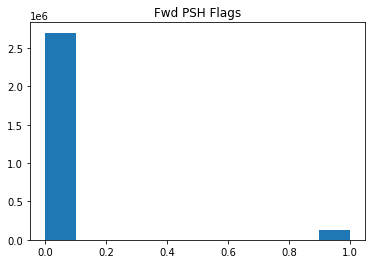

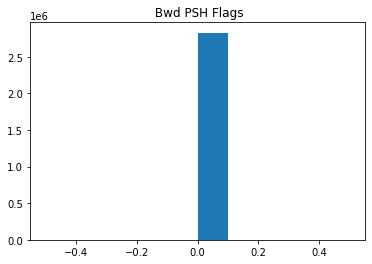

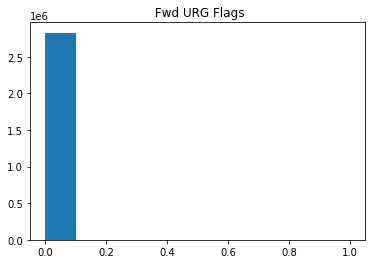

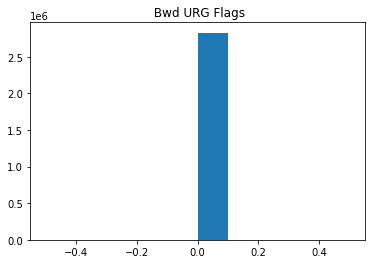

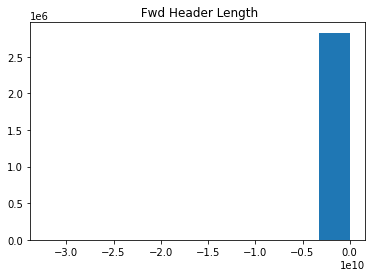

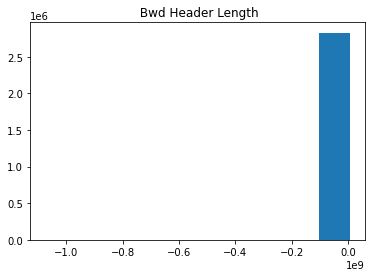

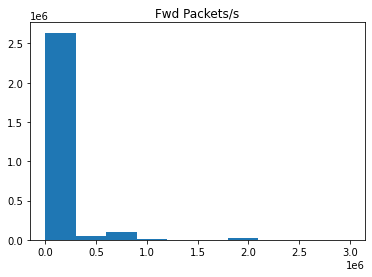

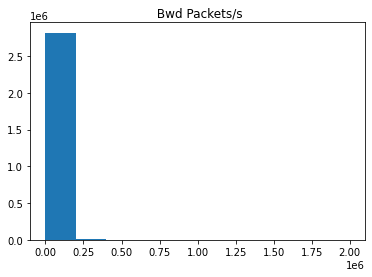

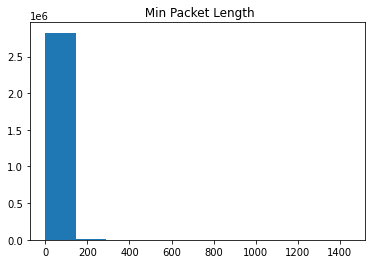

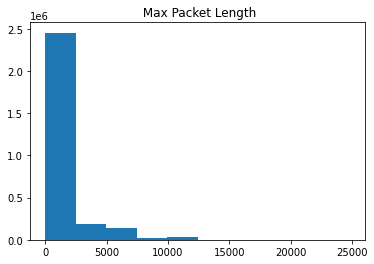

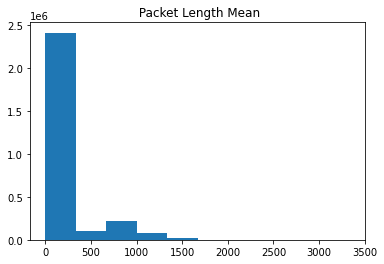

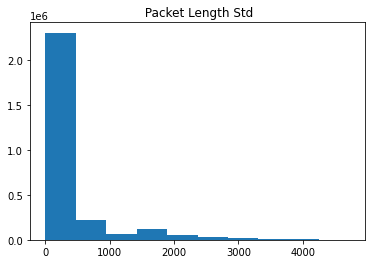

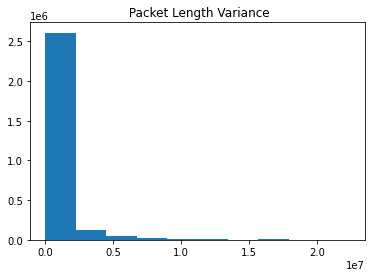

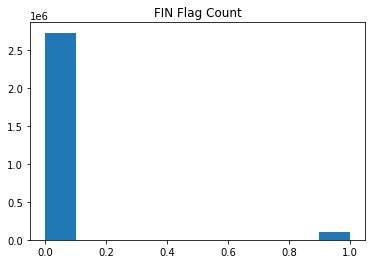

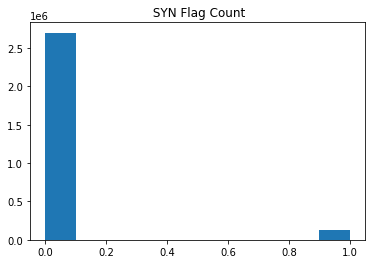

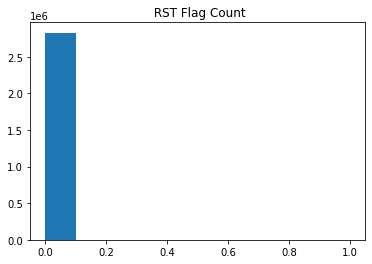

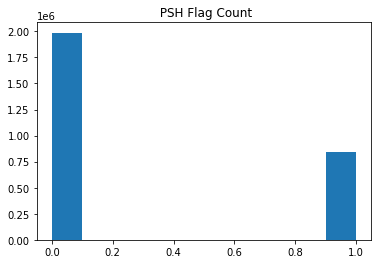

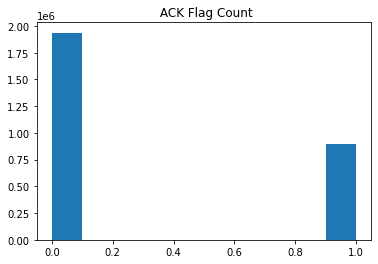

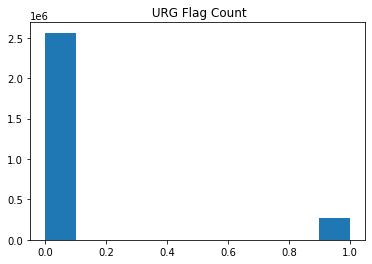

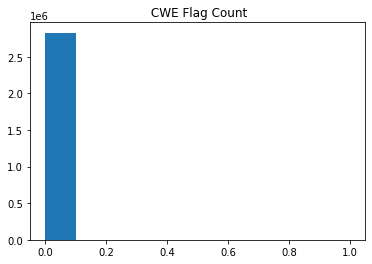

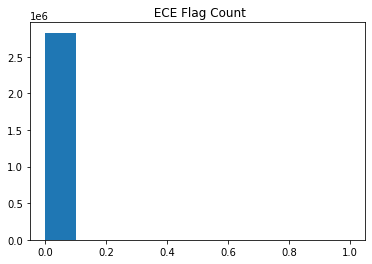

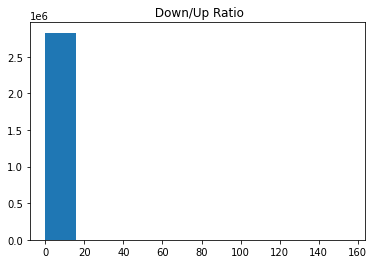

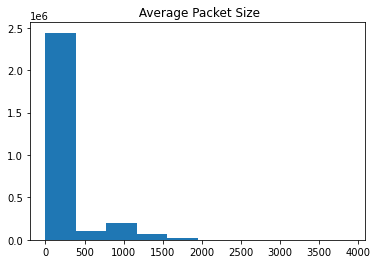

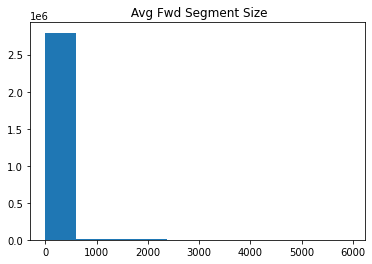

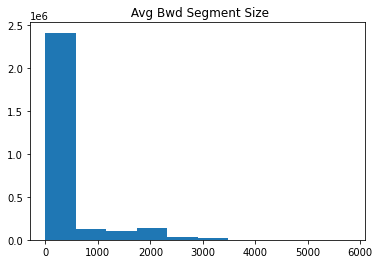

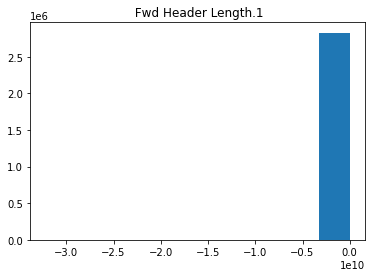

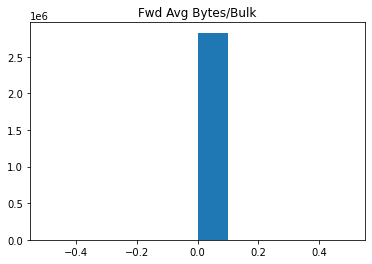

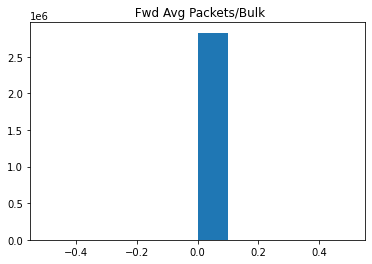

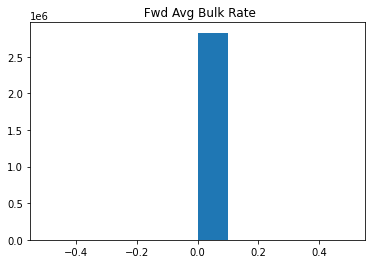

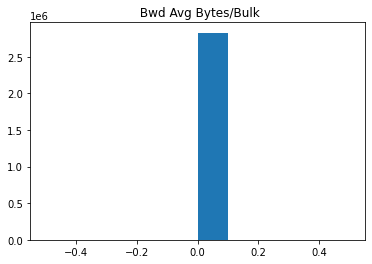

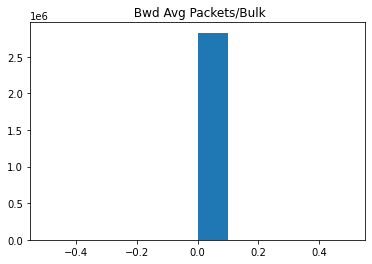

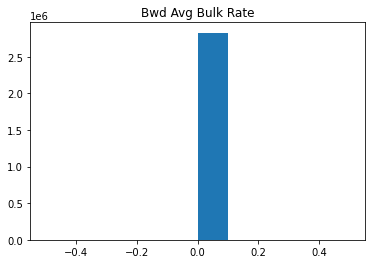

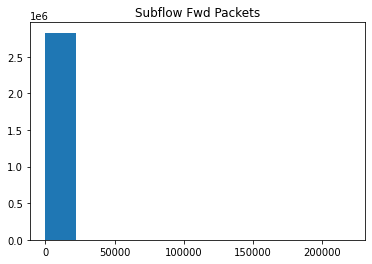

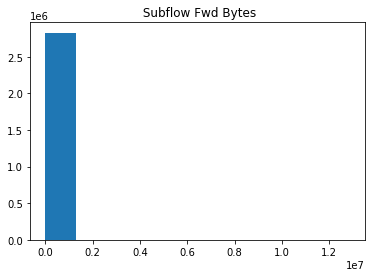

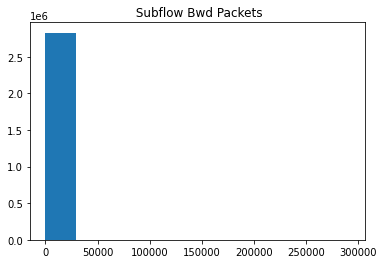

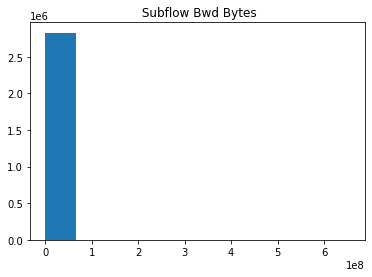

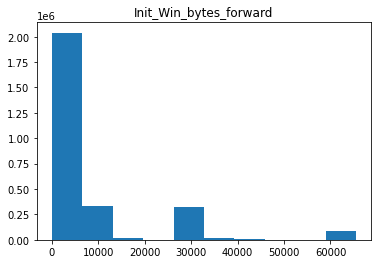

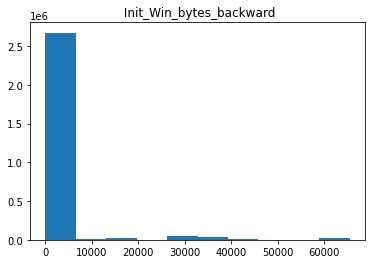

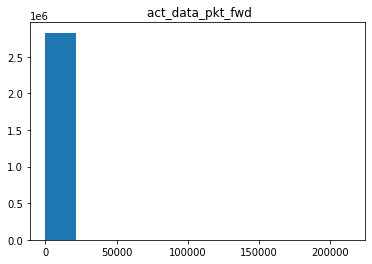

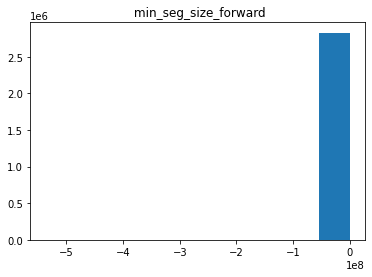

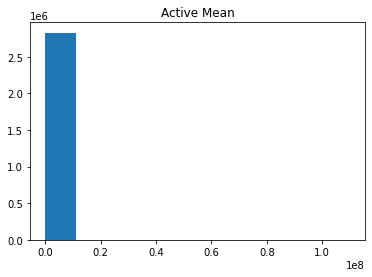

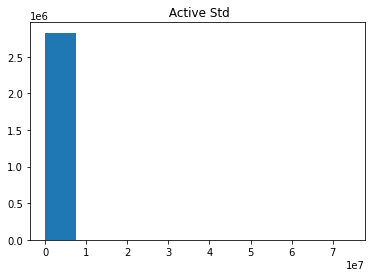

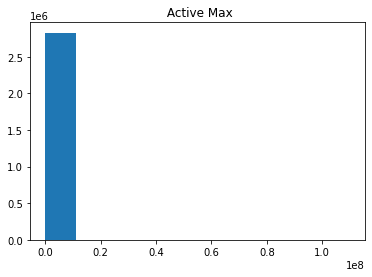

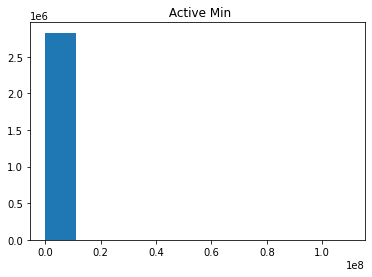

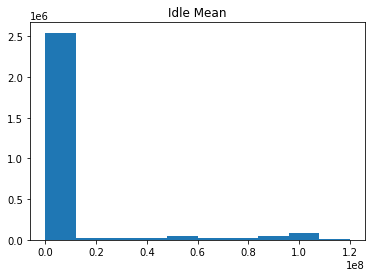

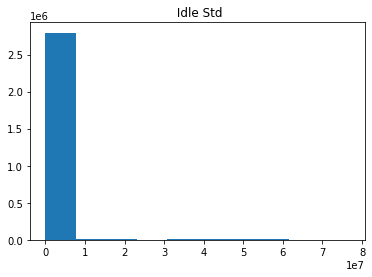

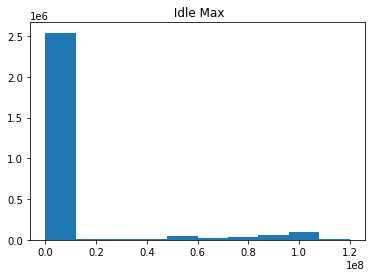

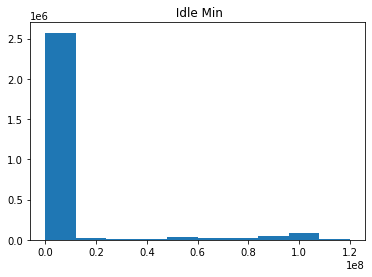

In [6]:
def histogram_dataframe(df):
    for colname in df.columns:
        col = df[colname]
    #     print(colname, col.dtypes)
        if col.dtypes in ['int64','float64']:
    #         print(len(col)-sum(np.isfinite(col)), sum(pd.isna(col)), sum(pd.isnull(col)),
    #               max(col[np.isfinite(col)]), min(col[np.isfinite(col)]),len(col.unique()))
            plt.title(colname)
            plt.hist(col[np.isfinite(col)])
            plt.show()

In [7]:
for colname in df.columns:
    col = df[colname]
#     print(colname, col.dtypes)
    if col.dtypes in ['int64','float64']:
        print(col.dtypes,len(col)-sum(np.isfinite(col)), sum(pd.isna(col)), sum(pd.isnull(col)),
              max(col[np.isfinite(col)]), min(col[np.isfinite(col)]),len(col.unique()))

int64 0 0 0 65535 0 53805
int64 0 0 0 119999998 -13 1050899
int64 0 0 0 219759 1 1432
int64 0 0 0 291922 0 1747
int64 0 0 0 12900000 0 17928
int64 0 0 0 655453030 0 64698
int64 0 0 0 24820 0 5279
int64 0 0 0 2325 0 384
float64 0 0 0 5940.857143 0.0 99716
float64 0 0 0 7125.5968458437 0.0 253909
int64 0 0 0 19530 0 4838
int64 0 0 0 2896 0 583
float64 0 0 0 5800.5 0.0 147614
float64 0 0 0 8194.660487 0.0 248869
float64 2867 1358 1358 2071000000.0 -261000000.0 1593909
float64 2867 0 0 4000000.0 -2000000.0 1240164
float64 0 0 0 120000000.0 -13.0 1166311
float64 0 0 0 84800261.5664079 0.0 1056642
int64 0 0 0 120000000 -13 580289
int64 0 0 0 120000000 -14 136316
int64 0 0 0 120000000 0 493098
float64 0 0 0 120000000.0 0.0 737737
float64 0 0 0 84602929.2769822 0.0 700313
int64 0 0 0 120000000 0 437316
int64 0 0 0 120000000 -12 110631
int64 0 0 0 120000000 0 414928
float64 0 0 0 120000000.0 0.0 670824
float64 0 0 0 84418013.7826341 0.0 709042
int64 0 0 0 120000000 0 368285
int64 0 0 0 12000000

In [86]:
labels = df[' Label'].unique()
lb_count = []
for lb in labels:
    lb_count.append(sum(df[' Label']==lb))
    print(lb,",",sum(df[' Label']==lb))

BENIGN , 2273097
Web Attack � Brute Force , 1507
Web Attack � XSS , 652
Web Attack � Sql Injection , 21
Infiltration , 36
DDoS , 128027
Bot , 1966
DoS slowloris , 5796
DoS Slowhttptest , 5499
DoS Hulk , 231073
DoS GoldenEye , 10293
Heartbleed , 11
PortScan , 158930
FTP-Patator , 7938
SSH-Patator , 5897


In [87]:
labels = df_nodup[' Label'].unique()
lb_count = []
for lb in labels:
    lb_count.append(sum(df_nodup[' Label']==lb))
    print(lb,",",sum(df_nodup[' Label']==lb))

BENIGN , 2096484
Web Attack � Brute Force , 1470
Web Attack � XSS , 652
Web Attack � Sql Injection , 21
Infiltration , 36
DDoS , 128016
Bot , 1953
DoS slowloris , 5385
DoS Slowhttptest , 5228
DoS Hulk , 172849
DoS GoldenEye , 10286
Heartbleed , 11
PortScan , 90819
FTP-Patator , 5933
SSH-Patator , 3219


In [ ]:
cn = ' Destination Port'
attrs = df[cn].unique()
attr_count = []
for att in attrs:
    if sum(df[cn]==att)>100:
        attr_count.append(sum(df[cn]==att))
        print(att,",",sum(df[cn]==att))

389 , 6406
0 , 1696
443 , 505710
53 , 957971
123 , 23880
5353 , 697
138 , 1612
137 , 7917
88 , 5580
3268 , 2567
5355 , 386
135 , 1412
49671 , 334
49666 , 786
445 , 2111
8612 , 107
3289 , 141
42 , 287
1124 , 362
49175 , 246
80 , 618934
49155 , 237
21 , 13522
1031 , 231
465 , 3817
1900 , 354
49156 , 237
49157 , 240
49159 , 223
49158 , 239
1028 , 229
1029 , 229
1038 , 225
1040 , 228
1052 , 220
1045 , 224
1044 , 222
1062 , 222
1063 , 222
22 , 16941
1061 , 231
1068 , 226
1076 , 226
1078 , 225
1077 , 226
1079 , 227
1080 , 234
1084 , 230
1104 , 222
1086 , 231
1110 , 226
1119 , 228
1121 , 230
1126 , 222
1132 , 230
1131 , 226
1151 , 227
1152 , 227
1148 , 227
1147 , 232
1073 , 225
1072 , 224
1165 , 222
1164 , 229
1097 , 230
1105 , 222
1095 , 227
1092 , 225
1088 , 229
1091 , 228
1138 , 224
1123 , 225
1130 , 230
1154 , 229
1145 , 224
1174 , 229
1183 , 228
1069 , 227
1070 , 227
1175 , 230
1066 , 225
1075 , 228
1085 , 230
1098 , 232
1106 , 225
1089 , 223
1090 , 226
1137 , 224
1083 , 226
139 , 2881
1

8045 , 224
49153 , 224
5959 , 217
8701 , 226
1755 , 226
49163 , 232
8300 , 218
5802 , 226
340 , 219
9900 , 222
8086 , 222
212 , 221
8873 , 225
616 , 222
7938 , 220
5862 , 221
8899 , 228
9917 , 225
6668 , 226
1277 , 223
524 , 220
19283 , 219
6547 , 232
38292 , 228
1023 , 221
6699 , 225
1027 , 228
6001 , 224
1002 , 219
2869 , 230
8649 , 220
1011 , 223
544 , 224
416 , 220
1033 , 220
1034 , 230
62078 , 227
9595 , 223
1032 , 226
1060 , 229
1050 , 223
8291 , 225
5269 , 227
8011 , 223
5120 , 223
6580 , 224
19 , 223
19315 , 219
3971 , 226
10778 , 223
1999 , 226
33354 , 231
2005 , 228
7676 , 228
5800 , 222
37 , 228
2021 , 226
888 , 227
2800 , 226
8085 , 223
9503 , 224
18988 , 221
1259 , 228
9009 , 220
6106 , 223
1782 , 226
13456 , 220
3766 , 232
9943 , 224
7443 , 229
8652 , 223
1935 , 223
58080 , 237
1688 , 226
6004 , 220
541 , 217
545 , 224
7496 , 224
32785 , 225
8007 , 228
691 , 224
2604 , 226
32775 , 230
9593 , 227
6059 , 233
3814 , 224
1065 , 226
1058 , 225
1055 , 219
11967 , 224
1718 , 222

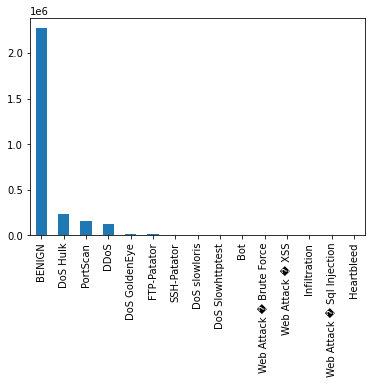

In [88]:
ax = df[' Label'].value_counts().plot(kind='bar')
# for i in range(len(labels)):
#     ax.text(i-0.2,100000, str(lb_count[i]), color='red', fontweight='bold')

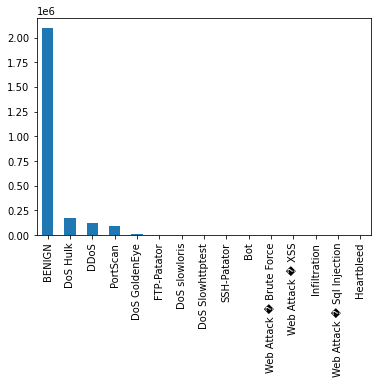

In [89]:
ax = df_nodup[' Label'].value_counts().plot(kind='bar')
# for i in range(len(labels)):
#     ax.text(i-0.2,100000, str(lb_count[i]), color='red', fontweight='bold')

In [10]:
print(labels)

['BENIGN' 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection' 'Infiltration' 'DDoS' 'Bot' 'DoS slowloris'
 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed' 'PortScan'
 'FTP-Patator' 'SSH-Patator']


# Classification

## Binary (attack/benign)

In [5]:
import torch

In [24]:
def set_binary_label(df, label_col, default_class='BENIGN'):
    df_y = df[label_col].copy()
    rep_class = {}
    lab_names = df_y.unique()
    for lab in lab_names:
        if lab == default_class:
            rep_class[lab] = 0
        else:
            rep_class[lab] = 1
    df_y.replace(rep_class)
    return df_y

def set_multiple_label(df, label_col, label_dic):
    df_y = df[label_col].copy()
    lab_names = df_y.unique()
    drop_idx = pd.Index([])
    for lab in lab_names:
        if lab in label_dic.keys():
#             print('pass', lab)
            pass
        else:
            print('drop', lab)
            drop_idx = drop_idx.append(df[df[label_col]==lab].index)  
    print("original instances: ",len(df))
    print("drop intances: ", len(drop_idx))
    df = df.drop(drop_idx)
    print("after drop: ",len(df))
#     del df_y, drop_idx
    df.replace({label_col:label_dic},inplace = True)
    return df

In [14]:
df_y = set_binary_label(df,label_col=' Label', default_class='BENIGN')

In [10]:
lab_cluster = {0: ['Web Attack � Brute Force','Web Attack � XSS','Web Attack � Sql Injection'],
             1: ['DDoS'],
             2: ['Bot'],
             3: ['DoS slowloris','DoS Slowhttptest','DoS Hulk','DoS GoldenEye'],
             4: ['PortScan'],
             5: ['FTP-Patator'],
             6: ['SSH-Patator']    
}
lab_dic = {}
for nlab in lab_cluster:
    for lab in lab_cluster[nlab]:
        lab_dic[lab] = nlab
print(lab_dic)

{'Web Attack � Brute Force': 0, 'Web Attack � XSS': 0, 'Web Attack � Sql Injection': 0, 'DDoS': 1, 'Bot': 2, 'DoS slowloris': 3, 'DoS Slowhttptest': 3, 'DoS Hulk': 3, 'DoS GoldenEye': 3, 'PortScan': 4, 'FTP-Patator': 5, 'SSH-Patator': 6}


In [25]:
df_mul = set_multiple_label(df_nodup,label_col=' Label', label_dic = lab_dic)

drop BENIGN
drop Infiltration
drop Heartbleed
original instances:  2830731
drop intances:  2273132
after drop:  557599


In [26]:
df_mul.head()

,index,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
12637,12637,80,5185118,7,7,1022,2321,372,0,146.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,0
12643,12643,80,5057374,10,7,736,9880,395,0,73.600000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,0
12700,12700,80,81,1,1,0,0,0,0,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,0
12712,12712,80,5271123,7,5,969,1430,561,0,138.428571,...,32,0.0,0.0,0,0,0.0,0.0,0,0,0
12791,12791,80,5020638,7,4,973,1430,565,0,139.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,0


<AxesSubplot:>

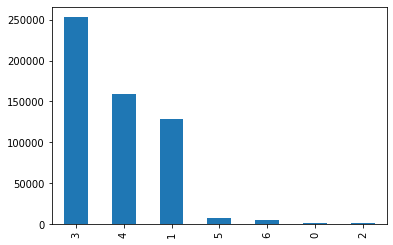

In [27]:
df_mul[' Label'].value_counts().plot(kind='bar')

In [ ]:
class CICDataset(Dataset):
    def __init__(self, df_x,df_y,select_idx=None):        
        if select_idx is None:
            self.x_tensor = torch.tensor(df_x.values,dtype=torch.float32)
            self.y_tensor = torch.tensor(df_y.values,dtype=torch.float32)
        else:
            self.x_tensor = torch.tensor(df_x[select_idx].values,dtype=torch.float32)
            self.y_tensor = torch.tensor(df_y[select_idx].values,dtype=torch.float32)
    def __len__(self):
        return len(self.y_tensor)
    def __getitem__(self,idx):
        return self.x_tensor[idx],self.y_tensor[idx]